In [1]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
import preprocessing
import os
import xrft
import gcm_filters
import random

warnings.filterwarnings("ignore")

importlib.reload(preprocessing)
from preprocessing import preprocess_data

from gcm_filtering import filter_inputs_dataset
from gcm_filtering import filter_inputs

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

from matplotlib.lines import Line2D

# Prep training data

In [2]:
ds_train1 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_trainingData_southAtlantic_every10TimeSteps_yr1.zarr", engine="zarr", chunks={}
) 
ds_train2 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_trainingData_southAtlantic_every10TimeSteps_yr2.zarr", engine="zarr", chunks={}
) 
ds_train3 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_trainingData_southAtlantic_every10TimeSteps_yr3.zarr", engine="zarr", chunks={}
) 
ds_train4 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_trainingData_southAtlantic_every10TimeSteps_yr4.zarr", engine="zarr", chunks={}
) 
ds_train5 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_trainingData_southAtlantic_every10TimeSteps_yr5.zarr", engine="zarr", chunks={}
) 
datasets = [ds_train1, ds_train2, ds_train3, ds_train4, ds_train5]

# Concatenate along the 'time' dimension
combined_dataset = xr.concat(datasets, dim='time')
combined_dataset

<xarray.Dataset> Size: 217MB
Dimensions:   (time: 185, yt_ocean: 163, xt_ocean: 150)
Coordinates:
  * time      (time) object 1kB 0181-01-01 12:00:00 ... 0185-12-26 12:00:00
  * xt_ocean  (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
  * yt_ocean  (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07
Data variables:
    q_ref     (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    slp       (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    sst       (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    t_ref     (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    u_rel     (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    v_rel     (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>

In [3]:
# Total number of samples
n_samples = len(combined_dataset.time)  # Assuming 'time' is the dimension

# Generate random indices
indices = np.arange(n_samples)
np.random.shuffle(indices)

# Split indices for training, validation, and testing
train_size = int(0.7 * n_samples)
val_size = int(0.15 * n_samples)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Select data using the indices
train_data = combined_dataset.isel(time=train_indices)
val_data = combined_dataset.isel(time=val_indices)
test_data = combined_dataset.isel(time=test_indices)

print("Training set size:", len(train_data.time))
print("Validation set size:", len(val_data.time))
print("Testing set size:", len(test_data.time))


Training set size: 129
Validation set size: 27
Testing set size: 29


In [4]:
# Extract TRAINING data
u_rel = train_data['u_rel'].values
v_rel = train_data['v_rel'].values
uv_sum = u_rel + v_rel

# Stack these arrays into a 4D tensor
# Shape will be (time, yt_ocean, xt_ocean, num_variables)
training_NN_inputs = torch.tensor(np.stack([u_rel, v_rel, uv_sum], axis=3))

# Now data_array is a 4D tensor
training_NN_inputs.shape

# Extract VALIDATION data
u_rel = val_data['u_rel'].values
v_rel = val_data['v_rel'].values
uv_sum = u_rel + v_rel

# Stack these arrays into a 4D tensor
# Shape will be (time, yt_ocean, xt_ocean, num_variables)
val_NN_inputs = torch.tensor(np.stack([u_rel, v_rel, uv_sum], axis=3))

# Now data_array is a 4D tensor
val_NN_inputs.shape

# Extract TESTING data
u_rel = test_data['u_rel'].values
v_rel = test_data['v_rel'].values
uv_sum = u_rel + v_rel

# Stack these arrays into a 4D tensor
# Shape will be (time, yt_ocean, xt_ocean, num_variables)
testing_NN_inputs = torch.tensor(np.stack([u_rel, v_rel, uv_sum], axis=3))

# Now data_array is a 4D tensor
testing_NN_inputs

tensor([[[[-5.8738,  6.7661,  0.8923],
          [-5.8305,  6.8215,  0.9910],
          [-5.7866,  6.8759,  1.0893],
          ...,
          [-1.9038,  7.9455,  6.0416],
          [-1.8977,  7.9531,  6.0553],
          [-1.8920,  7.9603,  6.0683]],

         [[-5.9470,  6.7755,  0.8285],
          [-5.9038,  6.8305,  0.9266],
          [-5.8602,  6.8845,  1.0243],
          ...,
          [-1.9608,  7.9692,  6.0084],
          [-1.9542,  7.9766,  6.0224],
          [-1.9478,  7.9836,  6.0357]],

         [[-6.0186,  6.7848,  0.7662],
          [-5.9756,  6.8393,  0.8637],
          [-5.9322,  6.8929,  0.9607],
          ...,
          [-2.0181,  7.9929,  5.9748],
          [-2.0109,  8.0001,  5.9892],
          [-2.0040,  8.0067,  6.0028]],

         ...,

         [[-8.9905,  7.9828, -1.0077],
          [-8.9600,  7.9875, -0.9725],
          [-8.9290,  7.9922, -0.9368],
          ...,
          [-2.6016,  4.4607,  1.8591],
          [-2.5791,  4.4380,  1.8589],
          [-2.5570,  4

# Set up NN architecture

In [5]:
class SimpleANN(nn.Module):
    def __init__(self, input_size, hidden_units, output_size):
        super(SimpleANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)  # First fully connected layer
        self.fc2 = nn.Linear(hidden_units, hidden_units)  # Hidden layer
        self.fc3 = nn.Linear(hidden_units, output_size)  # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation
        x = torch.relu(self.fc2(x))  # Apply ReLU activation
        x = self.fc3(x)  # Final layer (no activation if used for regression)
        return x

# Example setup
input_size = 2  # Number of input features
hidden_units = 64  # Number of neurons in the hidden layers
output_size = 1  # Single target output

model = SimpleANN(input_size, hidden_units, output_size)
print(model)

SimpleANN(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


In [6]:
class TensorDataset(Dataset):
    def __init__(self, tensor_data):
        self.tensor_data = tensor_data  # The 3D or 4D tensor dataset
        self.time_steps = tensor_data.shape[0]  # Total number of time steps

    def __len__(self):
        return self.time_steps  # Total number of samples (time steps)

    def __getitem__(self, idx):
        # Access the data at the specified index (time step)
        data = self.tensor_data[idx]  # Get data for the specified time step

        # Assuming the shape is (x, y, vars), extract variables as inputs and target
        # Flatten the spatial dimensions if they exist
        inputs = data.reshape(-1)[:2]  # Flatten inputs to a 1D vector (6 input features)
        
        # Extract the target, assuming it's the next variable (var 7)
        target = data.reshape(-1)[2]  # Replace 6 with the appropriate index for your target variable

        return inputs, target  # Return input (6 features) and target


# Training NN

In [7]:
train_dataset = TensorDataset(training_NN_inputs)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

In [8]:
val_dataset = TensorDataset(val_NN_inputs)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4)

In [9]:
criterion = nn.MSELoss()  # Use appropriate loss for your task
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
num_epochs = 500  # Number of epochs to train
loss_values = []
val_loss_values = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for inputs, targets in train_loader:
        # inputs shape: [batch_size, 2]
        # targets shape: [batch_size]

        # Convert inputs and targets to float32 (if necessary)
        inputs = inputs.float()
        targets = targets.float()

        # Zero/reset the parameter gradients before the next iteration
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)  # Shape: [batch_size, 1]

        # Compute loss
        loss = criterion(outputs.squeeze(), targets)  # Squeeze to match target shape if necessary

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # Accumulate running loss
        running_loss += loss.item()

    # Calculate average loss for the epoch
    average_loss = running_loss / len(train_loader)

    # Store average loss in the list
    loss_values.append(average_loss)

    # Validation phase (no gradient calculation)
    model.eval()  # Set model to evaluation mode
    val_running_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, targets in val_loader:
            # Convert inputs and targets to float32 (if necessary)
            inputs = inputs.float()
            targets = targets.float()

            # Forward pass
            outputs = model(inputs)  # Shape: [batch_size, 1]

            # Compute validation loss
            val_loss = criterion(outputs.squeeze(), targets)  # Squeeze to match target shape if necessary
            val_running_loss += val_loss.item()

    # Calculate average validation loss for the epoch
    average_val_loss = val_running_loss / len(val_loader)
    val_loss_values.append(average_val_loss)

    # Print epoch statistics
    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Training Loss: {average_loss:.4f}, Validation Loss: {average_val_loss:.4f}")

print("Training complete!")

Epoch [1/500], Training Loss: 26.4882, Validation Loss: 28.7432
Epoch [2/500], Training Loss: 24.8828, Validation Loss: 24.6328
Epoch [3/500], Training Loss: 16.9720, Validation Loss: 20.7550
Epoch [4/500], Training Loss: 15.4764, Validation Loss: 16.8497
Epoch [5/500], Training Loss: 17.9786, Validation Loss: 13.0362
Epoch [6/500], Training Loss: 10.1010, Validation Loss: 9.5276
Epoch [7/500], Training Loss: 6.7106, Validation Loss: 6.4641
Epoch [8/500], Training Loss: 4.2992, Validation Loss: 4.0662
Epoch [9/500], Training Loss: 3.6795, Validation Loss: 2.3075
Epoch [10/500], Training Loss: 1.5834, Validation Loss: 1.1628
Epoch [11/500], Training Loss: 0.8237, Validation Loss: 0.6447
Epoch [12/500], Training Loss: 0.5091, Validation Loss: 0.4768
Epoch [13/500], Training Loss: 0.4511, Validation Loss: 0.3938
Epoch [14/500], Training Loss: 0.4040, Validation Loss: 0.3421
Epoch [15/500], Training Loss: 0.3863, Validation Loss: 0.3083
Epoch [16/500], Training Loss: 0.4311, Validation Los

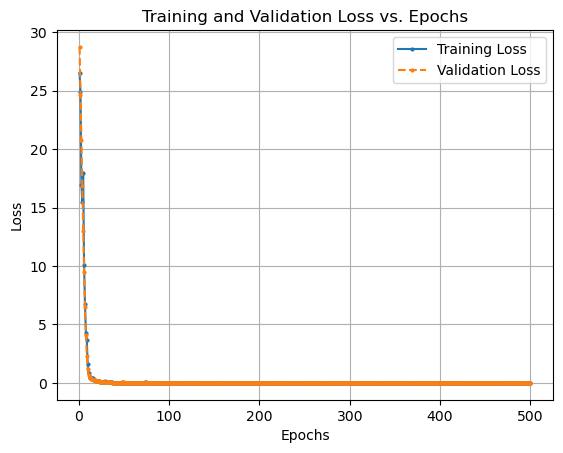

In [11]:
# Create a list for epochs
epochs_plot = list(range(1, num_epochs + 1))

# Plot training losses
plt.plot(epochs_plot, loss_values, marker='o', markersize=2, label='Training Loss')

# Plot validation losses
plt.plot(epochs_plot, val_loss_values, marker='o', markersize=2, label='Validation Loss', linestyle='--')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Epochs')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


# Testing dataset

In [12]:
# Flatten the input tensor to shape [num_samples, 3]
num_samples = testing_NN_inputs.shape[0] * testing_NN_inputs.shape[1] * testing_NN_inputs.shape[2]
testing_NN_inputs_flat = testing_NN_inputs.view(num_samples, 3)

# Create the test dataset and loader
test_dataset = TensorDataset(testing_NN_inputs_flat)  # Flattened tensor
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # Set shuffle=False for testing

In [13]:
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, targets in test_loader:
            # Ensure inputs and targets are float tensors
            inputs = inputs.float()  # Shape: [batch_size, 7]
            targets = targets.float()  # Shape: [batch_size]

            # Forward pass
            outputs = model(inputs)  # Shape: [batch_size, 1]

            # Calculate loss
            loss = criterion(outputs.squeeze(), targets)  # Match output and target shapes

            # Accumulate loss
            total_loss += loss.item()

            # Store predictions and targets (ensure they are 1-dimensional)
            all_predictions.append(outputs.squeeze(dim=-1))  # Ensure outputs are 1D
            all_targets.append(targets)  # Already 1D for ANN

    # Calculate average loss
    average_loss = total_loss / len(test_loader)

    # Concatenate lists into tensors
    all_predictions = torch.cat(all_predictions, dim=0)  # Shape: [num_test_samples]
    all_targets = torch.cat(all_targets, dim=0)  # Shape: [num_test_samples]

    return average_loss, all_predictions, all_targets


In [14]:
# Define your criterion (loss function)
criterion = nn.MSELoss()  # or whatever loss function you're using

# Evaluate the model on the test dataset
test_loss, predictions, targets = evaluate_model(model, test_loader, criterion)

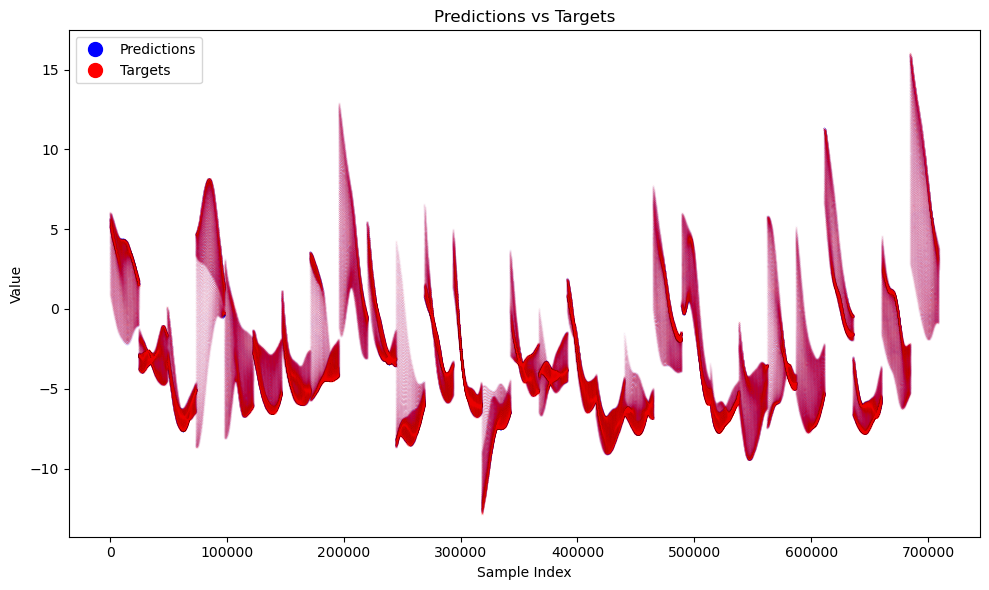

In [15]:
def plot_predictions_vs_targets(predictions, targets, num_samples=9, marker_size=20, legend_marker_size=10):
    # Ensure we're only plotting a limited number of samples
    num_samples = min(num_samples, predictions.shape[0])

    # Create a figure with a single subplot
    plt.figure(figsize=(10, 6))

    # Scatter plot predictions and targets with the specified marker sizes
    plt.scatter(range(num_samples), predictions[:num_samples].numpy(), label='Predictions', color='blue', marker='o', s=marker_size)
    plt.scatter(range(num_samples), targets[:num_samples].numpy(), label='Targets', color='red', marker='x', s=marker_size)

    # Create custom legend markers with no lines (only points)
    legend_handles = [
        Line2D([0], [0], marker='o', color='blue', markerfacecolor='blue', markersize=legend_marker_size, label='Predictions', linestyle=''),
        Line2D([0], [0], marker='o', color='red', markerfacecolor='red', markersize=legend_marker_size, label='Targets', linestyle='')
    ]

    # Add labels, title, and legend with custom markers
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.title('Predictions vs Targets')

    # Add the legend with custom handles (markers only)
    plt.legend(handles=legend_handles)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Assuming predictions and targets are your outputs from the evaluation function
plot_predictions_vs_targets(predictions, targets, num_samples=num_samples, marker_size=0.0001, legend_marker_size=10)


In [16]:
# Define a threshold for acceptable error margin (for regression)
threshold = 0.001  # You can change this based on your needs

# Function to evaluate the model on test data
def evaluate_model_on_test_data(model, test_loader, criterion, threshold=0.1):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    correct_predictions_count = 0  # To count predictions within the threshold

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, targets in test_loader:
            inputs = inputs.view(inputs.size(0), -1).float()  # Flatten inputs to shape [batch_size, 48900]
            targets = targets.float()  # Shape: [batch_size]

            # Forward pass: Get model predictions
            outputs = model(inputs)  # Shape: [batch_size, 1]

            # Compute loss (using MSELoss)
            loss = criterion(outputs.squeeze(), targets)  # Squeeze outputs to remove extra dimensions
            total_loss += loss.item()

            # Calculate "accuracy" based on the threshold
            correct_predictions = torch.abs(outputs.squeeze() - targets) <= threshold
            correct_predictions_count += correct_predictions.sum().item()

    # Calculate average loss for the test set
    average_loss = total_loss / len(test_loader)

    # Calculate accuracy as the ratio of correct predictions
    accuracy = correct_predictions_count / len(test_loader.dataset)

    return average_loss, accuracy

# After training, evaluate on the test set
test_loss, test_accuracy = evaluate_model_on_test_data(model, test_loader, criterion, threshold=0.1)

# Print the test results
print(f"Average Test Loss: {test_loss:.4f}, % of Accurate Predictions (within {threshold} margin): {test_accuracy * 100:.2f}%")

Average Test Loss: 0.0005, % of Accurate Predictions (within 0.001 margin): 99.76%


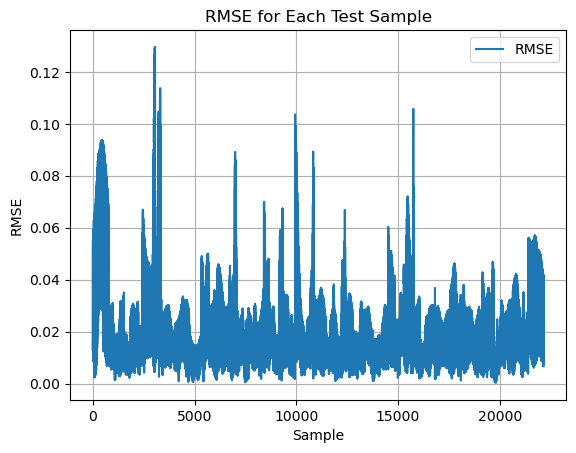

In [17]:
# Define function to calculate RMSE and plot it
def calculate_and_plot_rmse(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    rmse_values = []  # To store RMSE values for each sample

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, targets in test_loader:
            inputs = inputs.view(inputs.size(0), -1).float()  # Flatten inputs if needed
            targets = targets.float()  # Make sure targets are in float

            # Forward pass: Get model predictions
            outputs = model(inputs)  # Shape: [batch_size, 1]

            # Calculate squared differences between predictions and targets
            squared_diff = (outputs.squeeze() - targets) ** 2  # Squared differences

            # Calculate RMSE for the current batch
            rmse = torch.sqrt(squared_diff.mean())  # Square root of the mean squared differences
            rmse_values.append(rmse.item())  # Convert to Python scalar and store it

    # Plot RMSE values
    epochs_plot = list(range(1, len(rmse_values) + 1))
    plt.plot(epochs_plot, rmse_values, marker='o', markersize=0.001, label='RMSE')

    # Add labels and title
    plt.xlabel('Sample')
    plt.ylabel('RMSE')
    plt.title('RMSE for Each Test Sample')
    plt.grid(True)
    plt.legend()

    # Show the plot
    plt.show()

    # Return the RMSE values for further analysis if needed
    return rmse_values

# Assuming your model and test_loader are already defined, you can now call the function
rmse_values = calculate_and_plot_rmse(model, test_loader)

## Discussion

I switched this to an ANN and it worked way better. The ANN only has linear layers. The former CNN was good for non-linear cases, but was unneccesarily complex for this linear relation.